In [1]:
#!pip install torch torchvision torchaudio

In [2]:
# ==============================================================
# 🪐 SDSS Spectral Classification — PyTorch Notebook Skeleton
# ==============================================================
import pickle
import numpy as np
import torch
from collections import defaultdict
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
# Load both parts
spectra1 = np.load('../data/sdss_spectra_part1.npy', allow_pickle=True)
spectra2 = np.load('../data/sdss_spectra_part2.npy', allow_pickle=True)

# Combine into one array
spectra_list = np.concatenate([spectra1, spectra2], axis=0)


In [4]:
# --- Group spectra by class ---
by_class = defaultdict(list)
for s in spectra_list:
    by_class[s['class']].append(s)

# --- Find smallest class size ---
min_count = min(len(v) for v in by_class.values())
print("Balancing classes to", min_count, "each")

# --- Randomly sample each class to same count ---
balanced_list = []
for cls, items in by_class.items():
    balanced_list.extend(random.sample(items, min_count))

print("Total after balancing:", len(balanced_list))

spectra_list = balanced_list

Balancing classes to 712 each
Total after balancing: 2136


In [4]:
# --------------------------------------------------------------
# 2️⃣ Prepare wavelength grid and normalize
# --------------------------------------------------------------
# Define a fixed wavelength grid for interpolation
wave_grid = np.linspace(3800, 9200, 2000)

X, y = [], []
for s in spectra_list:
    flux_interp = np.interp(wave_grid, s['wavelength'], s['flux'], left=np.nan, right=np.nan)
    flux_interp = np.nan_to_num(flux_interp)
    flux_interp /= np.median(flux_interp) if np.median(flux_interp) != 0 else 1
    X.append(flux_interp)
    y.append(s['class'])

X = np.array(X, dtype=np.float32)
y = np.array(y)

# Encode class labels numerically
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print(f"Classes: {list(le.classes_)}")

Classes: ['GALAXY', 'QSO', 'STAR']


In [5]:
# --------------------------------------------------------------
# 3️⃣ PyTorch Dataset + split
# --------------------------------------------------------------
class SpectraDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:

dataset = SpectraDataset(X, y_encoded)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=50, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=50, shuffle=False)

In [7]:
# --------------------------------------------------------------
# 4️⃣ Define a simple 1D CNN or MLP
# --------------------------------------------------------------
class SpectraNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(16 * 500, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        x = x.unsqueeze(1)  
        return self.net(x)

In [8]:
model = SpectraNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)


SpectraNet(
  (net): Sequential(
    (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8000, out_features=64, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [9]:
# --------------------------------------------------------------
# 5️⃣ Training setup
# --------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

num_epochs = 15
train_losses, test_accuracies = [], []

In [10]:
# --------------------------------------------------------------
# 6️⃣ Training loop
# --------------------------------------------------------------
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            outputs = model(Xb)
            _, preds = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (preds == yb).sum().item()
    acc = 100 * correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")


Epoch 1/15 | Loss: 0.6361 | Test Acc: 84.04%
Epoch 2/15 | Loss: 0.3671 | Test Acc: 93.54%
Epoch 3/15 | Loss: 0.2359 | Test Acc: 94.14%
Epoch 4/15 | Loss: 0.1734 | Test Acc: 95.05%
Epoch 5/15 | Loss: 0.1298 | Test Acc: 95.35%
Epoch 6/15 | Loss: 0.1090 | Test Acc: 96.57%
Epoch 7/15 | Loss: 0.0960 | Test Acc: 96.77%
Epoch 8/15 | Loss: 0.0794 | Test Acc: 97.47%
Epoch 9/15 | Loss: 0.0678 | Test Acc: 97.07%
Epoch 10/15 | Loss: 0.0591 | Test Acc: 97.68%
Epoch 11/15 | Loss: 0.0566 | Test Acc: 97.27%
Epoch 12/15 | Loss: 0.0536 | Test Acc: 97.68%
Epoch 13/15 | Loss: 0.0442 | Test Acc: 97.17%
Epoch 14/15 | Loss: 0.0412 | Test Acc: 96.26%
Epoch 15/15 | Loss: 0.0361 | Test Acc: 97.47%


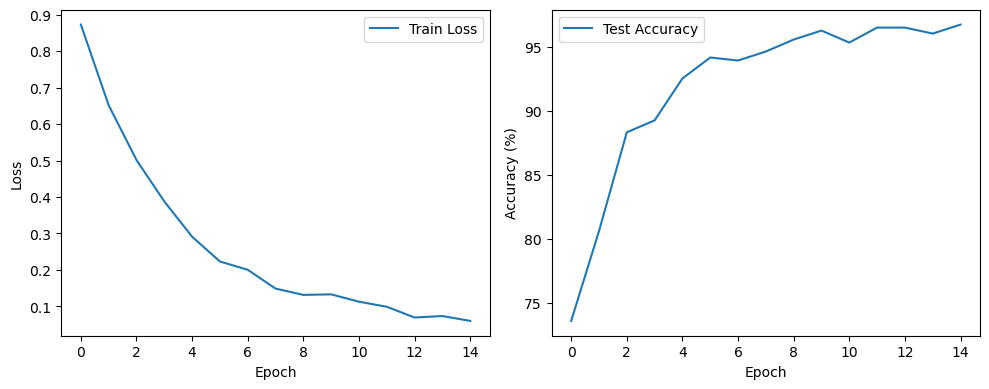

In [34]:
# --------------------------------------------------------------
# 7️⃣ Plot loss & accuracy
# --------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
plt.tight_layout(); plt.show()